# Questão 1

In [2]:
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt

In [3]:
# utilizei pytorch para as implementacoes das redes neurais
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
concrete_data = genfromtxt('concrete.csv', delimiter=',')
concrete_data.shape

(1030, 9)

## item a) 

In [5]:
concrete_data_X =  concrete_data[:, :-1]
concrete_data_y = concrete_data[:, [-1]]

In [6]:
class ModeloRegressao(nn.Module):
    
    def __init__(self, in_features= 8, h1= 8, out_features = 1):
        super(ModeloRegressao, self).__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.out = nn.Linear(h1, out_features)
    
    def forward(self, x):
        x = F.relu(self.fc1(x)) # definir
        x = self.out(x)
        return x

# definindo erro relativo medio, que nao tem implementacao nativa em pytorch
class MeanRelativeError(nn.Module):
    def __init__(self, epsilon=1e-8):
        super(MeanRelativeError, self).__init__()
        self.epsilon = epsilon 

    def forward(self, y_pred, y_true):
        relative_error = torch.abs((y_true - y_pred) / (y_true + self.epsilon)) # evitando divisao por zero
        return torch.mean(relative_error)


#### Split treino/teste/validação (60/20/20)

In [7]:
from sklearn.model_selection import train_test_split
X_treino_concrete, X_teste_concrete, y_treino_concrete, y_teste_concrete = train_test_split(concrete_data_X, concrete_data_y, test_size=0.2, random_state=1)
y_treino_concrete = y_treino_concrete.squeeze(1) # Ajustando a dimensão
y_teste_concrete = y_teste_concrete.squeeze(1) 

X_treino2_concrete, X_validacao_concrete, y_treino2_concrete, y_validacao_concrete = train_test_split(X_treino_concrete, y_treino_concrete, test_size=0.25, random_state=1) # 25% = (20/80) 


In [1]:
def ModelLosses(train_loader, test_loader, epochs = 300, lr = 0.01): 

    modelo = ModeloRegressao()
    optimizer = torch.optim.SGD(modelo.parameters(), lr=lr, momentum=0.9)

    mse_loss = nn.MSELoss()  # Mean Squared Error 
    mae_loss = nn.L1Loss()   # Mean Absolute Error
    mre_loss = MeanRelativeError() # Mean Relative Error

    train_losses_rmse = []
    train_losses_mse = []
    train_losses_mre = []
    train_losses_mae = []

    test_losses_rmse = []
    test_losses_mse = []
    test_losses_mae = []
    test_losses_mre = []


    for epoch in range(epochs):
        # ---- Treino ----
        modelo.train()
        total_train_loss_rmse = 0
        total_train_loss_mse = 0
        total_train_loss_mre = 0 
        total_train_loss_mae = 0

        for batch_X, batch_y in train_loader:
            outputs = modelo(batch_X)
  
            mae = mae_loss(outputs, batch_y)
            mre = mre_loss(outputs, batch_y)
            mse = mse_loss(outputs, batch_y)
            rmse = torch.sqrt(mse)
            
            optimizer.zero_grad()   # Limpa gradientes antigos
            mse.backward()          # Backpropagation com mse
            optimizer.step()        # Atualiza os pesos com SGD e termo de momento
            
            # Computando acuracias e funcao custo
            total_train_loss_rmse += rmse.item()
            total_train_loss_mse += mse.item() 
            total_train_loss_mre += mre.item() 
            total_train_loss_mae += mae.item() 


        avg_train_loss_mse = total_train_loss_mse / len(train_loader)
        train_losses_mse.append(avg_train_loss_mse)
        avg_train_loss_mre = total_train_loss_mre / len(train_loader)
        train_losses_mre.append(avg_train_loss_mre)
        avg_train_loss_mae = total_train_loss_mae / len(train_loader)
        train_losses_mae.append(avg_train_loss_mae)
        avg_train_loss_rmse = total_train_loss_rmse / len(train_loader)
        train_losses_rmse.append(avg_train_loss_rmse)

            
        # ---- Validação ----
        modelo.eval()
        total_test_loss_rmse = 0
        total_test_loss_mse = 0
        total_test_loss_mre = 0
        total_test_loss_mae = 0
        with torch.no_grad():
            for test_X, test_y in test_loader:
                outputs = modelo(test_X)

                mae = mae_loss(outputs, test_y)
                mre = mre_loss(outputs, test_y)
                mse = mse_loss(outputs, test_y)
                rmse = torch.sqrt(mse)

                total_test_loss_rmse += rmse.item()
                total_test_loss_mse += mse.item()
                total_test_loss_mre += mre.item()
                total_test_loss_mae += mae.item()

        avg_test_loss_rmse = total_test_loss_rmse / len(test_loader)
        avg_test_loss_mse = total_test_loss_mse / len(test_loader)
        avg_test_loss_mre = total_test_loss_mre / len(test_loader)
        avg_test_loss_mae = total_test_loss_mae / len(test_loader)

        test_losses_rmse.append(avg_test_loss_rmse)
        test_losses_mse.append(avg_test_loss_mse)
        test_losses_mre.append(avg_test_loss_mre)
        test_losses_mae.append(avg_test_loss_mae)

        train_losses = [train_losses_mse, train_losses_mae, train_losses_mre, train_losses_rmse]
        test_losses = [test_losses_mse, test_losses_mae, test_losses_mre, test_losses_rmse]

    return train_losses, test_losses

#### Normalizando o conjunto de treino e validação

In [8]:
from sklearn.preprocessing import StandardScaler

scaler1 = StandardScaler()
X_treino2_concrete_norm = scaler1.fit_transform(X_treino2_concrete)
X_validacao_concrete_norm = scaler1.transform(X_validacao_concrete)
y_treino2_concrete_norm = scaler1.fit_transform(y_treino2_concrete.reshape(-1, 1))
y_validacao_concrete_norm = scaler1.transform(y_validacao_concrete.reshape(-1, 1))

# Convertendo para tensores
X_treino2_concrete_norm = torch.tensor(X_treino2_concrete_norm, dtype=torch.float32)
X_validacao_concrete_norm = torch.tensor(X_validacao_concrete_norm, dtype=torch.float32)
y_treino2_concrete_norm = torch.tensor(y_treino2_concrete_norm, dtype=torch.float32)
y_validacao_concrete_norm = torch.tensor(y_validacao_concrete_norm, dtype=torch.float32)

#### Random Search para o passo de aprendizagem e tamanho de batch

In [9]:
lr_range = [0.0001, 0.01]

batch_size_choices = [16, 32, 64]

In [10]:
from torch.utils.data import DataLoader, TensorDataset
import random 


trials = 10 # numero de tentativas 

best_val_loss = float('inf')
best_params = None
best_model_state = None

for _ in range(trials):
    
    val_losses = []

    # escolha aleatoria dos hiperparametros
    lr = 10 ** random.uniform(np.log10(lr_range[0]), np.log10(lr_range[1]))
    batch_size = random.choice(batch_size_choices)
    
    # instanciando o modelo
    modelo = ModeloRegressao()
    optimizer = torch.optim.SGD(modelo.parameters(), lr=lr, momentum=0.9)
    loss_fn = nn.CrossEntropyLoss()

    # loaders
    train_dataset = TensorDataset(X_treino2_concrete_norm, y_treino2_concrete_norm)
    val_dataset  = TensorDataset(X_validacao_concrete_norm, y_validacao_concrete_norm)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader  = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    _, val_losses = ModelLosses(train_loader, val_loader, epochs = 300, lr = lr) # estamos considerando o melhor modelo como o que tem menor mse no conjunto validacao

    # considere o ultimo valor da funcao custo como o menor(pode necessitar de analise melhor em casos em que ocorre overfitting)
    avg_val_loss = val_losses[0][-1] 

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_params = {
            'learning_rate': lr,
            'batch_size': batch_size
        }

In [11]:
lr = best_params['learning_rate']    
batch_size = best_params['batch_size']
print(f'Passo de aprendizagem: {lr}\nTamanho da batch: {batch_size}')

Passo de aprendizagem: 0.007778538570528983
Tamanho da batch: 64


In [12]:
train_dataset = TensorDataset(X_treino2_concrete_norm, y_treino2_concrete_norm)
val_dataset  = TensorDataset(X_validacao_concrete_norm, y_validacao_concrete_norm)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader  = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

train_losses, val_losses = ModelLosses(train_loader, val_loader, epochs = 300, lr = lr)

epochs = 300

#### Preparando modelo final (treinado com treino+validacao)  

In [13]:
# normalizacao
scaler3 = StandardScaler()
X_treino_concrete_norm = scaler3.fit_transform(X_treino_concrete)
X_teste_concrete_norm = scaler3.transform(X_teste_concrete)
y_treino_concrete_norm = scaler1.fit_transform(y_treino_concrete.reshape(-1, 1))
y_teste_concrete_norm = scaler1.transform(y_teste_concrete.reshape(-1, 1))

# Convertendo para tensores
X_treino_concrete_norm = torch.tensor(X_treino_concrete_norm, dtype=torch.float32)
X_teste_concrete_norm = torch.tensor(X_teste_concrete_norm, dtype=torch.float32)
y_treino_concrete_norm = torch.tensor(y_treino_concrete_norm, dtype=torch.float32)
y_teste_concrete_norm = torch.tensor(y_teste_concrete_norm, dtype=torch.float32)


In [14]:
train_full_dataset = TensorDataset(X_treino_concrete_norm, y_treino_concrete_norm)  # treino + validacao
test_dataset = TensorDataset(X_teste_concrete_norm, y_teste_concrete_norm)

train_full_loader = DataLoader(train_full_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_full_losses, test_losses = ModelLosses(train_full_loader, test_loader, epochs=300, lr=lr)

## item b)

#### MSE para os conjuntos de treino, validação e teste

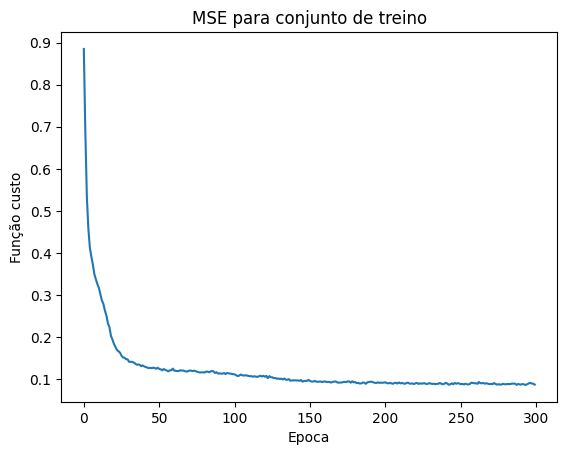

In [15]:
plt.plot(range(epochs), train_losses[0])
plt.title('MSE para conjunto de treino')
plt.ylabel('Função custo')
plt.xlabel('Epoca')
plt.show()

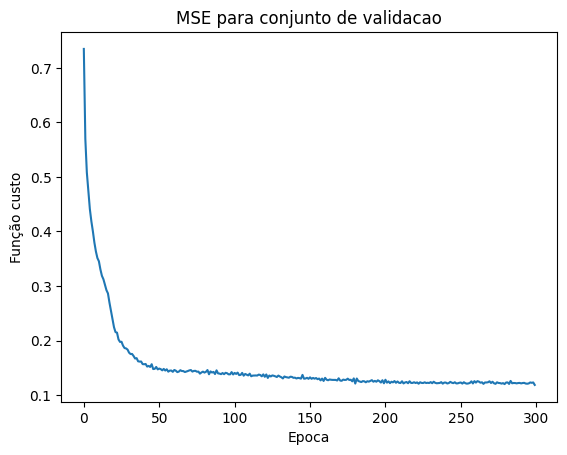

In [16]:
plt.plot(range(epochs), val_losses[0])
plt.title('MSE para conjunto de validacao')
plt.ylabel('Função custo')
plt.xlabel('Epoca')
plt.show()

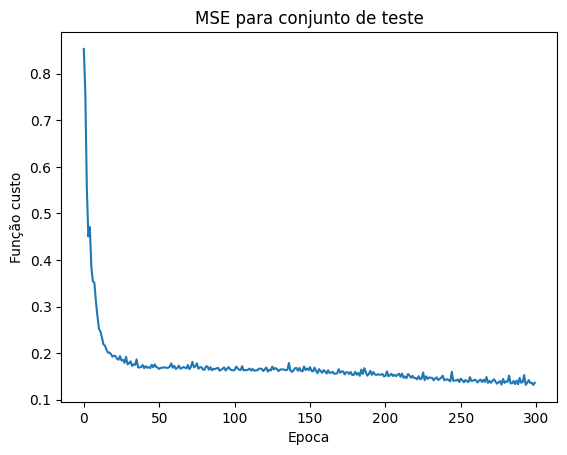

In [17]:
plt.plot(range(epochs), test_losses[0])
plt.title('MSE para conjunto de teste')
plt.ylabel('Função custo')
plt.xlabel('Epoca')
plt.show()

#### MRE para os conjuntos de treino, validação e teste

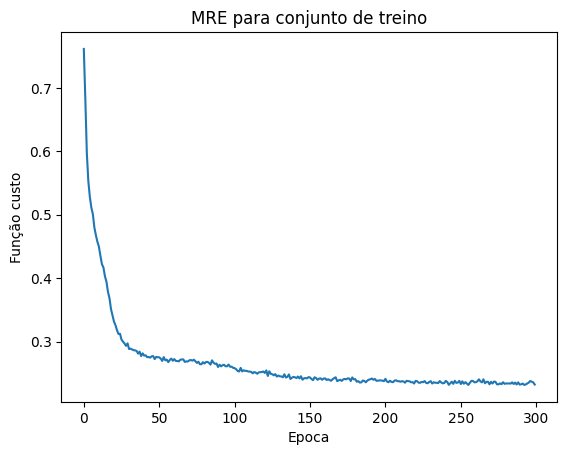

In [18]:
plt.plot(range(epochs), train_losses[1])
plt.title('MRE para conjunto de treino')
plt.ylabel('Função custo')
plt.xlabel('Epoca')
plt.show()

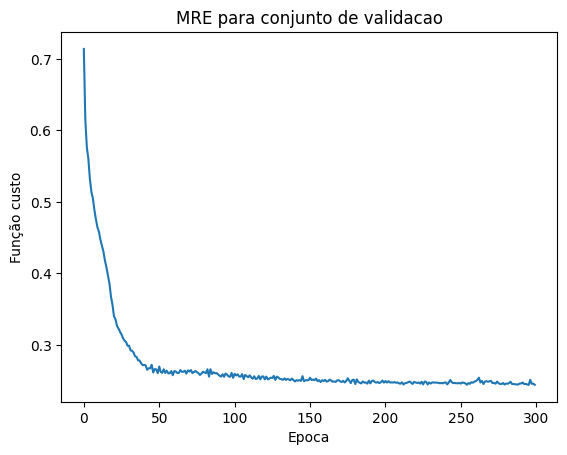

In [19]:
plt.plot(range(epochs), val_losses[1])
plt.title('MRE para conjunto de validacao')
plt.ylabel('Função custo')
plt.xlabel('Epoca')
plt.show()

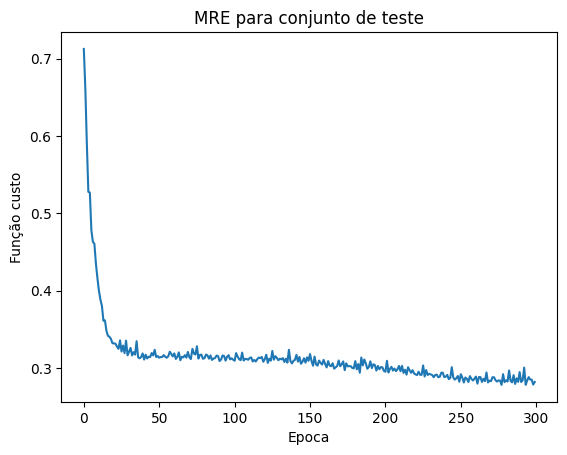

In [20]:
plt.plot(range(epochs), test_losses[1])
plt.title('MRE para conjunto de teste')
plt.ylabel('Função custo')
plt.xlabel('Epoca')
plt.show()

#### MAE para os conjuntos de treino, validação e teste

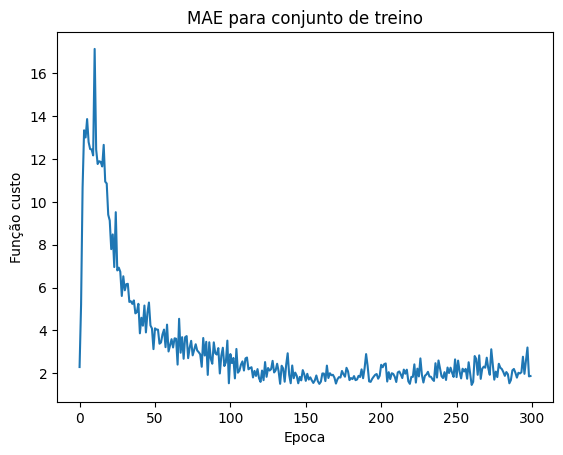

In [21]:
plt.plot(range(epochs), train_losses[2])
plt.title('MAE para conjunto de treino')
plt.ylabel('Função custo')
plt.xlabel('Epoca')
plt.show()

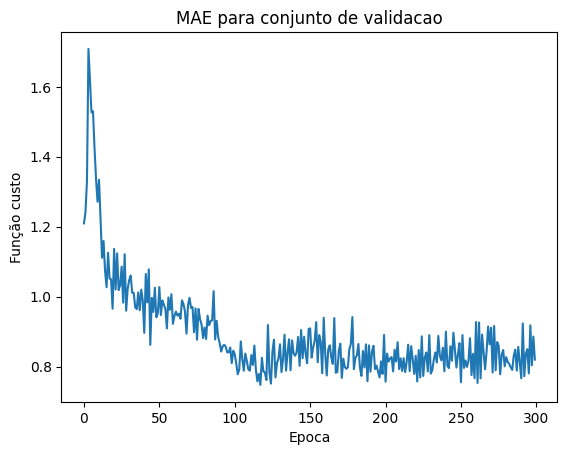

In [22]:
plt.plot(range(epochs), val_losses[2])
plt.title('MAE para conjunto de validacao')
plt.ylabel('Função custo')
plt.xlabel('Epoca')
plt.show()

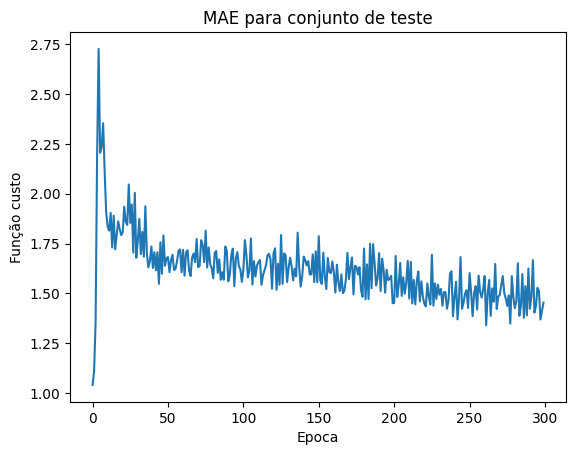

In [24]:
plt.plot(range(epochs), test_losses[2])
plt.title('MAE para conjunto de teste')
plt.ylabel('Função custo')
plt.xlabel('Epoca')
plt.show()

#### RMSE para os conjuntos de treino, validação e teste

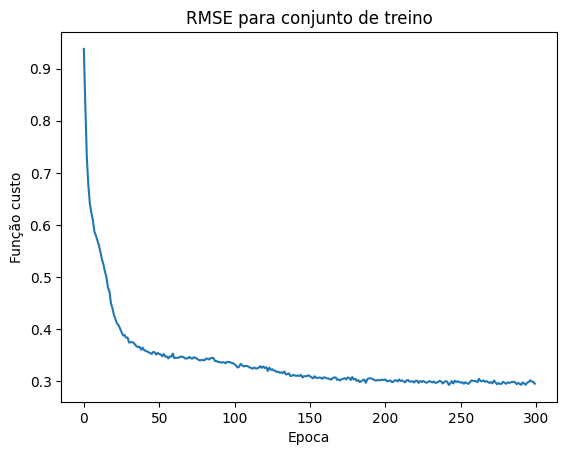

In [25]:
plt.plot(range(epochs), train_losses[3])
plt.title('RMSE para conjunto de treino')
plt.ylabel('Função custo')
plt.xlabel('Epoca')
plt.show()

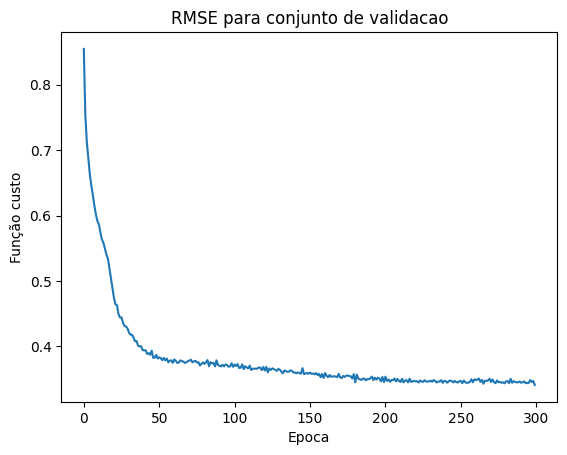

In [26]:
plt.plot(range(epochs), val_losses[3])
plt.title('RMSE para conjunto de validacao')
plt.ylabel('Função custo')
plt.xlabel('Epoca')
plt.show()

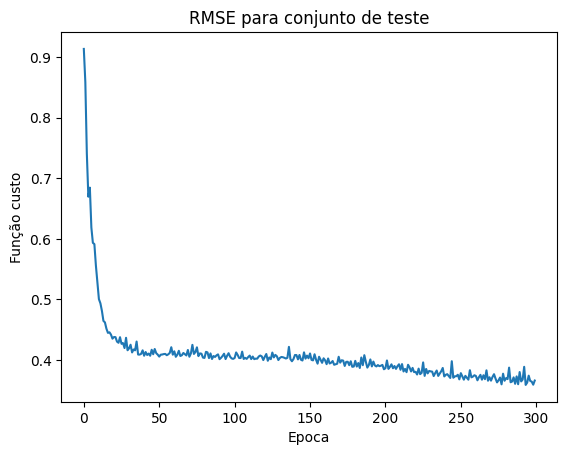

In [27]:
plt.plot(range(epochs), test_losses[3])
plt.title('RMSE para conjunto de teste')
plt.ylabel('Função custo')
plt.xlabel('Epoca')
plt.show()

# Questão 2

In [ ]:
class ModeloClassificacao(nn.Module):
    
    def __init__(self, in_features= 10, h1= 8, out_features = 11):
        super(ModeloClassificacao, self).__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.out = nn.Linear(h1, out_features)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.out(x)
        return x

In [4]:
vowel_data = genfromtxt('vowel.csv', delimiter=',')
vowel_data.shape

(990, 11)

## item a)

#### Split treino/teste/validação (60/20/20)

In [5]:
vowel_data_X =  vowel_data[:, :-1]
vowel_data_y = vowel_data[:, [-1]]

In [ ]:
X_treino_vowel, X_teste_vowel, y_treino_vowel, y_teste_vowel = train_test_split(vowel_data_X, vowel_data_y, test_size=0.2, random_state=1)
y_treino_vowel = y_treino_vowel.squeeze(1) # Ajustando a dimensão
y_teste_vowel = y_teste_vowel.squeeze(1) 

In [ ]:
X_treino2_vowel, X_validacao_vowel, y_treino2_vowel, y_validacao_vowel = train_test_split(X_treino_vowel, y_treino_vowel, test_size=0.25, random_state=1) # 25% = (20/80) 


In [82]:
def ModelMetrics(train_loader, test_loader, epochs = 300, lr = 0.01): 

    modelo = ModeloClassificacao()
    optimizer = torch.optim.SGD(modelo.parameters(), lr=lr, momentum=0.9)
    loss_fn = nn.CrossEntropyLoss()


    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        # ---- Treino ----
        modelo.train()
        total_train_loss = 0
        total_correct = 0     
        total_samples = 0     
        for batch_X, batch_y in train_loader:
            outputs = modelo(batch_X)
            loss = loss_fn(outputs, batch_y)
            
            optimizer.zero_grad()   # Limpa gradientes antigos
            loss.backward()         # Backpropagation
            optimizer.step()        # Atualiza os pesos com SGD e termo de momento
            
            # Computando acuracias e funcao custo
            total_train_loss += loss.item() 

            predictions = torch.argmax(outputs, dim=1)
            total_correct += (predictions == batch_y).sum().item()
            total_samples += batch_y.size(0)

        avg_train_loss = total_train_loss / len(train_loader)
        train_accuracy = total_correct / total_samples

        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

            
        # ---- Validação ----
        modelo.eval()
        total_correct = 0
        total_samples = 0
        total_test_loss = 0
        with torch.no_grad():
            for test_X, test_y in test_loader:
                outputs = modelo(test_X)
                loss = loss_fn(outputs, test_y)

                total_test_loss += loss.item()
                predictions = torch.argmax(outputs, dim=1)  
                correct = (predictions == test_y).sum().item()
                total_correct += correct
                total_samples += test_y.size(0)
                    
        avg_test_loss = total_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

        test_accuracy = total_correct / total_samples
        test_accuracies.append(test_accuracy)

    return train_losses, train_accuracies, test_losses, test_accuracies

#### Normalizando o conjunto de treino e validação

In [ ]:
scaler = StandardScaler()
X_treino2_vowel_norm = scaler.fit_transform(X_treino2_vowel)
X_validacao_vowel_norm = scaler.transform(X_validacao_vowel)

# Convertendo para tensores
X_treino2_vowel_norm = torch.tensor(X_treino2_vowel_norm, dtype=torch.float32)
y_treino2_vowel = torch.tensor(y_treino2_vowel, dtype=torch.long)
X_validacao_vowel_norm = torch.tensor(X_validacao_vowel_norm, dtype=torch.float32)
y_validacao_vowel = torch.tensor(y_validacao_vowel, dtype=torch.long)

#### Random Search para o passo de aprendizagem e tamanho de batch

In [84]:
lr_range = [0.0001, 0.01]

batch_size_choices = [16, 32, 64]

In [181]:
trials = 10 # numero de tentativas 

best_val_loss = float('inf')
best_params = None
best_model_state = None

for _ in range(trials):
    
    val_losses = []

    # escolha aleatoria dos hiperparametros
    lr = 10 ** random.uniform(np.log10(lr_range[0]), np.log10(lr_range[1]))
    batch_size = random.choice(batch_size_choices)
    
    # instanciando o modelo
    modelo = ModeloClassificacao()
    optimizer = torch.optim.SGD(modelo.parameters(), lr=lr, momentum=0.9)
    loss_fn = nn.CrossEntropyLoss()

    # loaders
    train_dataset = TensorDataset(X_treino2_vowel_norm, y_treino2_vowel)
    val_dataset  = TensorDataset(X_validacao_vowel_norm, y_validacao_vowel)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader  = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    _, _, val_losses, _ = ModelMetrics(train_loader, val_loader, epochs = 300, lr = lr) # estamos considerando o melhor modelo como o que tem menor erro no conjunto de validacao

    # considere o ultimo valor da funcao custo como o menor(pode necessitar de analise melhor em casos em que ocorre overfitting)
    avg_val_loss = val_losses[-1] 

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_params = {
            'learning_rate': lr,
            'batch_size': batch_size
        }


In [182]:
lr = best_params['learning_rate']    
batch_size = best_params['batch_size']
print(f'Passo de aprendizagem: {lr}\nTamanho da batch: {batch_size}')

Passo de aprendizagem: 0.009571117069168928
Tamanho da batch: 32


In [183]:
train_dataset = TensorDataset(X_treino2_vowel, y_treino2_vowel)
val_dataset  = TensorDataset(X_validacao_vowel, y_validacao_vowel)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader  = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

epochs = 300


In [195]:
train_losses, train_accuracies, val_losses, val_accuracies = ModelMetrics(train_loader, val_loader, epochs = 300, lr = lr)

## item b)

#### Função custo para os conjuntos de teste e validação

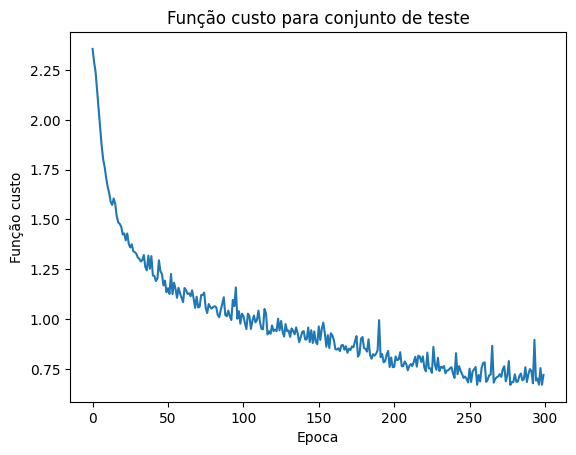

In [196]:
plt.plot(range(epochs), val_losses)
plt.title('Função custo para conjunto de teste')
plt.ylabel('Função custo')
plt.xlabel('Epoca')
plt.show()

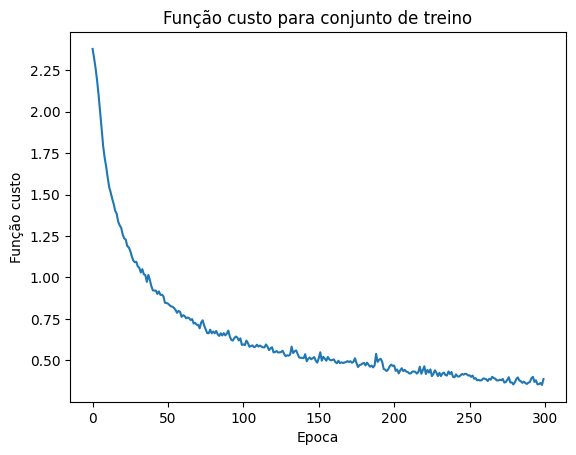

In [197]:
plt.plot(range(epochs), train_losses)
plt.title('Função custo para conjunto de treino')
plt.ylabel('Função custo')
plt.xlabel('Epoca')
plt.show()

#### Acurácias para treino, validação e teste

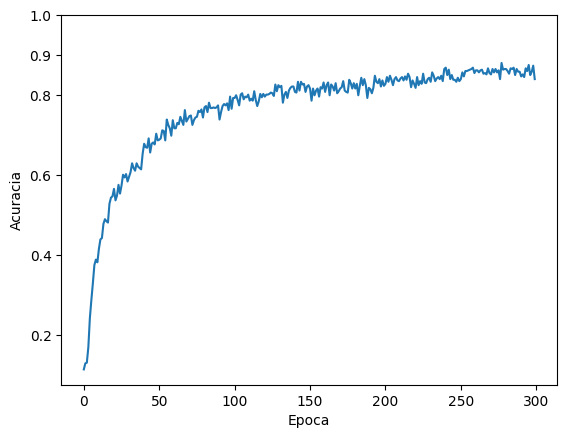

In [198]:
plt.plot(range(epochs), train_accuracies)
plt.ylabel('Acuracia')
plt.yticks([0.2, 0.4, 0.6, 0.8, 0.9, 1.0])
plt.xlabel('Epoca')
plt.show()

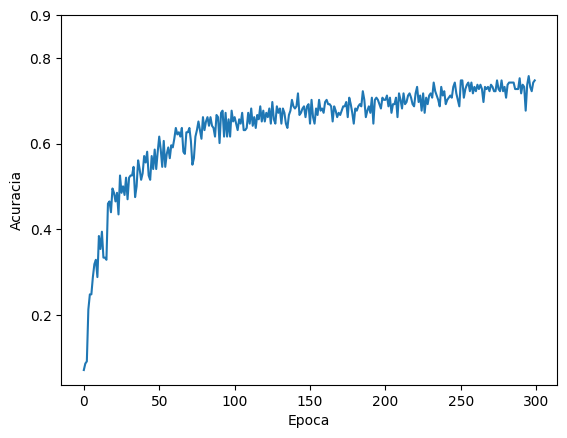

In [199]:
plt.plot(range(epochs), val_accuracies)
plt.ylabel('Acuracia')
plt.yticks([0.2, 0.4, 0.6, 0.8, 0.9])
plt.xlabel('Epoca')
plt.show()

In [ ]:
# normalizacao

scaler2 = StandardScaler()
X_treino_vowel_norm = scaler2.fit_transform(X_treino_vowel)
X_teste_vowel_norm = scaler2.transform(X_teste_vowel)

# Convertendo para tensores
X_treino_vowel_norm = torch.tensor(X_treino_vowel_norm, dtype=torch.float32)
X_teste_vowel_norm = torch.tensor(X_teste_vowel_norm, dtype=torch.float32)
y_treino_vowel = torch.tensor(y_treino_vowel, dtype=torch.long)
y_teste_vowel = torch.tensor(y_teste_vowel, dtype=torch.long)


In [ ]:
train_full_dataset = TensorDataset(X_treino_vowel_norm, y_treino_vowel) # treinamento com o conjunto de treino cheio(treino + validacao)
test_dataset  = TensorDataset(X_teste_vowel_norm, y_teste_vowel)

train_full_loader = DataLoader(train_full_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_full_losses, train_full_accuracies, test_losses, test_accuracies = ModelMetrics(train_full_loader, test_loader, epochs = 300, lr = lr)

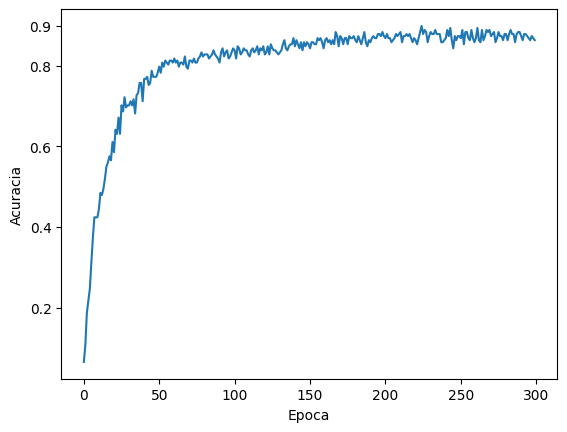

In [202]:
plt.plot(range(epochs), test_accuracies)
plt.ylabel('Acuracia')
plt.yticks([0.2, 0.4, 0.6, 0.8, 0.9])
plt.xlabel('Epoca')
plt.show()

#### Matriz de confusão p/ conjunto de teste

In [203]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

modelo = ModeloClassificacao()
optimizer = torch.optim.SGD(modelo.parameters(), lr=lr, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()
epochs = 300

modelo.train()
for _ in range(epochs):

    for batch_X, batch_y in train_full_loader:
        outputs = modelo(batch_X)
        loss = loss_fn(outputs, batch_y)
            
        optimizer.zero_grad()   
        loss.backward()        
        optimizer.step()        

modelo.eval()

all_preds = []
all_labels = []


with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = modelo(batch_X)
        predictions = torch.argmax(outputs, dim=1)

        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())


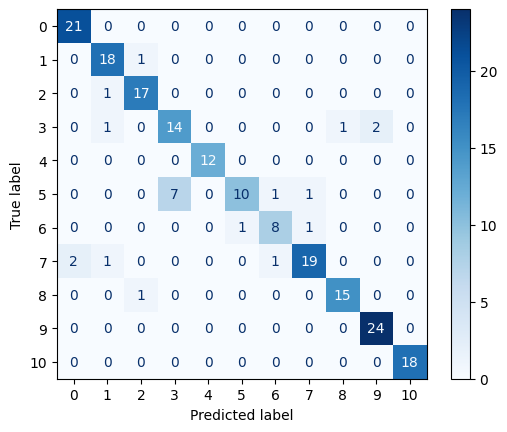

In [204]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')